In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
import warp_prism
import sqlalchemy as sa
import talib
import matplotlib.pyplot as plt
import seaborn
pd.set_option('precision', 4)

/home/alex/env/lib/python3.6/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
metadata = sa.MetaData()
engine = sa.create_engine('postgresql://developer:1@localhost:5432/go_finance')
tbl_prices = sa.Table(
    'prices', metadata,
    sa.Column('symbol', sa.String(16)),
    sa.Column('dt', sa.Date),
    sa.Column('open', sa.FLOAT),
    sa.Column('high', sa.FLOAT),
    sa.Column('low', sa.FLOAT),
    sa.Column('close', sa.FLOAT),
    sa.Column('volume', sa.BIGINT),
    sa.Column('adj', sa.FLOAT),
)

In [3]:
symbol = 'SPY'
query = sa.select(tbl_prices.c).where(
    tbl_prices.c.symbol.in_(['SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLI', 'XLV', 'XLP', 'XLF', 'XLU', 'XLY', 'XLB'])
).where(
    tbl_prices.c.dt >= (date(2004, 1, 1) - timedelta(days=400)).strftime('%Y-%m-%d')
).order_by('symbol', 'dt')

is_adjusted = False
df = warp_prism.to_dataframe(query, bind=engine)

fltr = df['dt'] >= '2004-01-01'
print(df[fltr].iloc[0])

df.head()

symbol                    DIA
dt        2004-01-02 00:00:00
open                      105
high                    105.5
low                       104
close                   104.4
volume                8231300
adj                     73.29
Name: 275, dtype: object


,symbol,dt,open,high,low,close,volume,adj
0,DIA,2002-11-27,87.65,89.65,87.59,89.53,8264700,61.4775
1,DIA,2002-11-29,89.70,89.80,88.82,88.90,3058100,61.0449
2,DIA,2002-12-02,90.40,90.66,88.03,88.87,8928700,61.0243
3,DIA,2002-12-03,88.20,88.39,87.42,87.93,7011500,60.3788
4,DIA,2002-12-04,86.94,88.40,86.70,87.75,9947600,60.2552


In [4]:
# adjust
if not is_adjusted:
    ratio = df.adj / df.close
    df['open'] *= ratio
    df['high'] *= ratio
    df['low'] *= ratio
    df['close'] *= ratio
    df['volume'] = (df['volume'] / ratio).astype(int)
    is_adjusted = True
df.head()

,symbol,dt,open,high,low,close,volume,adj
0,DIA,2002-11-27,60.1866,61.5599,60.1454,61.4775,12035925,61.4775
1,DIA,2002-11-29,61.5942,61.6629,60.9900,61.0449,4453526,61.0449
2,DIA,2002-12-02,62.0749,62.2534,60.4475,61.0243,13002911,61.0243
3,DIA,2002-12-03,60.5642,60.6947,60.0286,60.3788,10210888,60.3788
4,DIA,2002-12-04,59.6990,60.7015,59.5342,60.2552,14486748,60.2552


# Smooth ROC

In [5]:
period = 200
roc = talib.ROC(df['close'].values, timeperiod=period)
df['roc200'] = roc
df['roc200_smooth'] = (df['roc200'] + df['roc200'].shift(1)*2 + df['roc200'].shift(2)*2 + df['roc200'].shift(3)) / 6 
df.tail()

,symbol,dt,open,high,low,close,volume,adj,roc200,roc200_smooth
47227,XLY,2018-07-12,112.02,112.43,111.530,112.34,2914209,112.34,26.8610,26.1137
47228,XLY,2018-07-13,112.41,112.77,112.230,112.59,5523716,112.59,27.1291,26.4383
47229,XLY,2018-07-16,112.87,113.05,112.435,112.87,3096416,112.87,26.7503,26.7481
47230,XLY,2018-07-17,111.70,113.23,111.470,112.98,4071940,112.98,27.0293,26.9415
47231,XLY,2018-07-18,112.91,113.31,112.550,112.91,6406110,112.91,26.4714,26.8600


In [6]:
def get_drawdown(series, is_prod=False):
    total = len(series.index)
    if is_prod:
        series = series.rolling(total, min_periods=1).apply(np.prod)
    rolling_max = series.rolling(total, min_periods=1).max()
    daily_drawdown = series/rolling_max - 1.0
    daily_drawdown_max = daily_drawdown.rolling(total, min_periods=1).min()
    return daily_drawdown_max.min()

def get_strategy_returns(df, symbol='-'):
    fltr = df['dt'] >= '2004-01-01'
    calc_returns = lambda x: (np.prod(x) - 1) * 100
    
    # get price changes
    chg = (df.close / df.close.shift(1))[fltr]
    chg.iloc[0] = 1  # set first value as 1

    benchmark = chg
    sma200_chg = chg[(df.close.rolling(1).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    sma50x200_chg = chg[(df.close.rolling(50).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    
    ema50 = talib.EMA(df.close.values, timeperiod=50)
    ema200 = talib.EMA(df.close.values, timeperiod=200)
    ema50x200_chg = chg[np.roll(ema50 - ema200, 1)[fltr] >= 0]

    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200_chg = chg[np.roll(roc200, 1)[fltr] >= 0]

    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200smooth = (roc200 + np.roll(roc200, 1)*2 + np.roll(roc200, 2)*2 + np.roll(roc200, 3)) / 6
    roc200s_chg = chg[np.roll(roc200smooth, 1)[fltr] >= 0]

    roc5 = talib.ROC(df.close.values, timeperiod=5)
    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc5x200_chg = chg[np.roll(roc5 - roc200, 1)[fltr] >= 0]
    
    rsi_up = 45
    
    rsi50 = talib.RSI(df.close.values, timeperiod=50)
    rsi50_chg = chg[np.roll(rsi50, 1)[fltr] >= rsi_up]
    
    rsi100 = talib.RSI(df.close.values, timeperiod=100)
    rsi100_chg = chg[np.roll(rsi100, 1)[fltr] >= rsi_up]

    returns = {
        'symbol': symbol, 
        'bench': calc_returns(benchmark),
        'bench dd': get_drawdown(benchmark, is_prod=True) * 100,
        's200': calc_returns(sma200_chg[fltr]),
        's50x200': calc_returns(sma50x200_chg[fltr]),
        's50x200 dd': get_drawdown(sma50x200_chg[fltr], is_prod=True) * 100,
        'e50x200': calc_returns(ema50x200_chg[fltr]),
        'e50x200 dd': get_drawdown(ema50x200_chg[fltr], is_prod=True) * 100,
        'roc200': calc_returns(roc200_chg[fltr]),
        'roc200 dd': get_drawdown(roc200_chg[fltr], is_prod=True) * 100,
        'roc200s': calc_returns(roc200s_chg[fltr]),
        'roc5x200': calc_returns(roc5x200_chg[fltr]),
        'rsi50': calc_returns(rsi50_chg[fltr]),
        'rsi100': calc_returns(rsi100_chg[fltr]),
    }
    return returns

l = []
for symbol in df.symbol.unique():
    l.append(get_strategy_returns(df[df.symbol == symbol], symbol))
    
print("Returns & Drawdowns")
pd.DataFrame(l).sort_values('symbol')

Returns & Drawdowns


,bench,bench dd,e50x200,e50x200 dd,roc200,roc200 dd,roc200s,roc5x200,rsi100,rsi50,s200,s50x200,s50x200 dd,symbol
0,243.8720,-51.8694,229.1137,-19.5597,179.8891,-23.3394,173.6951,-6.0817,176.6514,81.1176,129.4237,239.3117,-23.7096,DIA
1,264.8206,-59.0453,210.5532,-26.6661,108.6221,-39.9853,131.3106,32.4152,194.5375,136.0209,95.1357,131.8766,-37.8055,IWM
2,456.3612,-53.4040,298.4315,-29.3527,189.1254,-26.9391,251.1645,55.5594,501.2702,368.9718,218.5561,226.8197,-26.0499,QQQ
3,237.8994,-55.1894,216.9814,-18.9325,147.8131,-33.6410,135.2896,-2.6295,172.3992,108.3173,155.8856,237.2446,-19.1790,SPY
4,203.9051,-59.8292,147.4624,-29.2318,75.4393,-41.8105,122.4155,27.3490,258.6882,152.7035,21.2443,151.2327,-24.9551,XLB
5,65.2301,-82.6872,176.4054,-28.2106,104.0590,-39.7909,97.1943,-29.5409,-4.0481,5.0789,108.7982,192.1724,-30.2858,XLF
6,271.5647,-62.2632,269.5462,-23.6545,228.3271,-27.6842,194.6460,16.5627,267.1344,327.7892,183.9791,204.3528,-30.0123,XLI
7,333.0599,-53.0393,227.8467,-24.6339,136.8673,-30.4945,128.9027,53.3337,289.6434,227.7469,190.1202,161.9511,-24.5829,XLK
8,249.6215,-32.3903,183.2995,-21.8896,154.5775,-18.6106,216.6045,10.3292,187.4715,108.6796,94.5980,124.1684,-26.1855,XLP
9,278.4450,-46.4766,218.0793,-24.9148,174.8749,-22.1493,217.4560,9.8375,300.4290,202.3316,94.8002,205.2229,-23.3583,XLU


Returns:  3.37899411628 Max Drawdown:  -0.551894401605 -0.551894401605


/home/alex/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


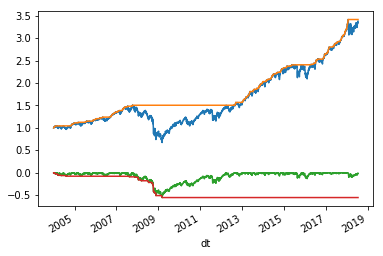

In [7]:
fltr = df['dt'] >= '2004-01-01'
data = df[fltr][df.symbol == 'SPY'].set_index('dt')
chg = (data.close / data.close.shift(1))
chg.iloc[0] = 1

total = len(chg.index)
chg = chg.rolling(total, min_periods=1).apply(np.prod)
rolling_max = chg.rolling(total, min_periods=1).max()
daily_drawdown = chg/rolling_max - 1.0
daily_drawdown_max = daily_drawdown.rolling(total, min_periods=1).min()
print('Returns: ', chg.iloc[-1], 'Max Drawdown: ', daily_drawdown_max.min(), get_drawdown(data.close))

chg.plot()
rolling_max.plot()
daily_drawdown.plot()
daily_drawdown_max.plot()
plt.show()

In [8]:
import io
tsv = """
	name	return	max drawdown	exposure
0	SPY, sma50x200	224.21	-19.43	79.492081
1	SPY, sma200	162.86	-17.69	80.611688
2	SPY, roc200	147.41	-31.75	83.096668
3	SPY, roc200 smooth	123.63	-35.94	82.768979
"""
pd.read_csv(io.StringIO(tsv), sep='\t', header=0)[['name', 'return', 'max drawdown', 'exposure']]

,name,return,max drawdown,exposure
0,"SPY, sma50x200",224.21,-19.43,79.4921
1,"SPY, sma200",162.86,-17.69,80.6117
2,"SPY, roc200",147.41,-31.75,83.0967
3,"SPY, roc200 smooth",123.63,-35.94,82.7690


In [9]:
def get_strategy_returns(df, symbol='-'):
    # фильтр периода
    fltr = df['dt'] >= '2004-01-01'
    # функция накопления доходности
    calc_returns = lambda x: (np.prod(x) - 1) * 100
    
    # получаем дневное изменение цены и оставляем необходимый период
    chg = (df.close / df.close.shift(1))[fltr]
    chg.iloc[0] = 1  # начинаем всегда с единицы

    benchmark = chg
    sma200_chg = chg[(df.close.rolling(1).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    sma50x200_chg = chg[(df.close.rolling(50).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    
    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200_chg = chg[np.roll(roc200, 1)[fltr] >= 0]

    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200smooth = (roc200 + np.roll(roc200, 1)*2 + np.roll(roc200, 2)*2 + np.roll(roc200, 3)) / 6
    roc200s_chg = chg[np.roll(roc200smooth, 1)[fltr] >= 0]
    
    returns = {
        'symbol': symbol, 
        'bench': calc_returns(benchmark),
        'bench dd': get_drawdown(benchmark, is_prod=True) * 100,
        's200': calc_returns(sma200_chg[fltr]),
        's200 dd': get_drawdown(sma200_chg[fltr], is_prod=True) * 100,
        's50x200': calc_returns(sma50x200_chg[fltr]),
        's50x200 dd': get_drawdown(sma50x200_chg[fltr], is_prod=True) * 100,
        'roc200': calc_returns(roc200_chg[fltr]),
        'roc200 dd': get_drawdown(roc200_chg[fltr], is_prod=True) * 100,
        'roc200s': calc_returns(roc200s_chg[fltr]),
        'roc200s dd': get_drawdown(roc200s_chg[fltr], is_prod=True) * 100,
    }
    return returns
l = []
for symbol in df.symbol.unique():
    l.append(get_strategy_returns(df[df.symbol == symbol], symbol))
    
print("Returns & Drawdowns")
pd.DataFrame(l).sort_values('symbol')

Returns & Drawdowns


,bench,bench dd,roc200,roc200 dd,roc200s,roc200s dd,s200,s200 dd,s50x200,s50x200 dd,symbol
0,243.8720,-51.8694,179.8891,-23.3394,173.6951,-20.4874,129.4237,-20.7875,239.3117,-23.7096,DIA
1,264.8206,-59.0453,108.6221,-39.9853,131.3106,-34.3266,95.1357,-28.7601,131.8766,-37.8055,IWM
2,456.3612,-53.4040,189.1254,-26.9391,251.1645,-24.9958,218.5561,-26.4412,226.8197,-26.0499,QQQ
3,237.8994,-55.1894,147.8131,-33.6410,135.2896,-32.4676,155.8856,-20.6767,237.2446,-19.1790,SPY
4,203.9051,-59.8292,75.4393,-41.8105,122.4155,-29.9843,21.2443,-45.3152,151.2327,-24.9551,XLB
5,65.2301,-82.6872,104.0590,-39.7909,97.1943,-41.7358,108.7982,-30.8172,192.1724,-30.2858,XLF
6,271.5647,-62.2632,228.3271,-27.6842,194.6460,-32.9876,183.9791,-24.4730,204.3528,-30.0123,XLI
7,333.0599,-53.0393,136.8673,-30.4945,128.9027,-26.0254,190.1202,-22.3531,161.9511,-24.5829,XLK
8,249.6215,-32.3903,154.5775,-18.6106,216.6045,-16.6489,94.5980,-20.8217,124.1684,-26.1855,XLP
9,278.4450,-46.4766,174.8749,-22.1493,217.4560,-15.0608,94.8002,-24.5642,205.2229,-23.3583,XLU


In [10]:
fltr = df['dt'] >= '2004-01-01'
prices = df[df.symbol == 'SPY'].close

# Расчёт доходности

SPY Returns: 237.90% PriceXSMA200: 155.89% SMA50X200: 237.24%


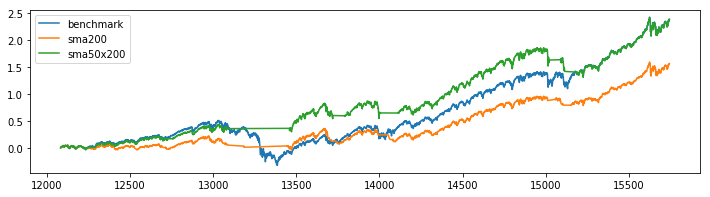

In [19]:
calc_returns = lambda x: (np.prod(x) - 1) * 100  # считаем итоговую доходность
    
# получаем дневное изменение цены
chg = (prices / prices.shift(1))[fltr]
chg.iloc[0] = 1  # начинаем всегда с единицы

# получаем пересечение цены и SMA200, и смещаем на 1 день вперёд
filter_changes = (df.close.rolling(1).mean() - df.close.rolling(200).mean()).shift(1) >= 0
sma200 = chg[filter_changes]

# получаем пересечение SMA50 и SMA200, и смещаем на 1 день вперёд
filter_changes = (df.close.rolling(50).mean() - df.close.rolling(200).mean()).shift(1) >= 0
sma50x200 = chg[filter_changes]

print('SPY Returns: {bench:.2f}% PriceXSMA200: {sma200:.2f}% SMA50X200: {sma50x200:.2f}%'.format(
    bench=calc_returns(chg), sma200=calc_returns(sma200), sma50x200=calc_returns(sma50x200)))

(chg.rolling(total, min_periods=1).apply(np.prod) - 1).rename('benchmark').plot(figsize=(12, 3), legend=True)
(sma200.rolling(total, min_periods=1).apply(np.prod) - 1).rename('sma200').plot(legend=True)
(sma50x200.rolling(total, min_periods=1).apply(np.prod) - 1).rename('sma50x200').plot(legend=True)
plt.show()

# Расчёт максимальной просадки

SPY Drawdown: -55.19%


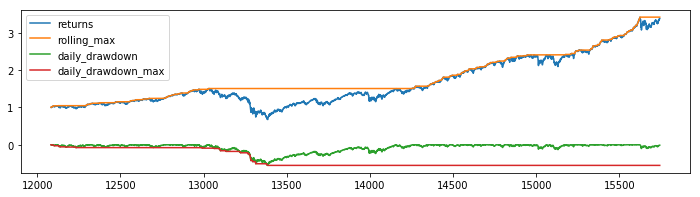

In [18]:
series = chg.copy()
total = len(series.index)
# получаем доходность на каждый день
series = series.rolling(total, min_periods=1).apply(np.prod)
# получаем обновление максимумов на каждый день
rolling_max = series.rolling(total, min_periods=1).max()
# получаем разницу максимума к цене на каждый день
daily_drawdown = series/rolling_max - 1.0
# получаем обновление минимумов просадки на каждый день
daily_drawdown_max = daily_drawdown.rolling(total, min_periods=1).min()
# выводим максимальную просадку
print('SPY Drawdown: {0:.2f}%'.format(daily_drawdown_max.min() * 100))

series.rename('returns').plot(figsize=(12, 3), legend=True)
rolling_max.rename('rolling_max').plot(legend=True)
daily_drawdown.rename('daily_drawdown').plot(legend=True)
daily_drawdown_max.rename('daily_drawdown_max').plot(legend=True)
plt.show()